In [1]:
import numpy as np
import pygsti as pig
import matplotlib.pyplot as plt
import random
import time
import pandas
from scipy.linalg import expm, sqrtm
import scipy as sp
# from qutip import *

from pygsti.modelmembers.operations import LindbladErrorgen as _LinbladErrorgen
from pygsti.modelmembers.operations import EmbeddedErrorgen as _EmbeddedErrorgen
from pygsti.modelmembers.operations import ExpErrorgenOp as _ExpErrorgenOp
from pygsti.modelmembers.operations import ComposedOp as _ComposedOp
import  pygsti.modelmembers as _mdmb
import pygsti.processors as _proc

from pygsti.tools import pdftools as _pdftools

from pygsti.circuits.gstcircuits import create_lsgst_circuits

from pygsti.models.memberdict import OrderedMemberDict as _OrderedMemberDict
from pygsti.baseobjs.label import Label as _Label, CircuitLabel as _CircuitLabel
from pygsti.circuits import Circuit
import pygsti.circuits as _circ
import pygsti.models as _mdl
from pygsti.modelmembers import operations as _op

In [2]:
def random_circuit(depth, proc_spec):
    """
    works for any 1-qubit model pack and the XYZICnot 2-qubit pack
    """
    layers = []
    for i in range(depth):
        gate = random.choice(proc_spec.gate_names)
        if gate == '(idle)':
            pass
        elif gate == 'Gcnot':
            layers.append((gate, 0, 1))
        else:
            layers.append((gate, random.choice(proc_spec.qubit_labels)))
    return Circuit(layers, proc_spec.qubit_labels)

In [3]:
def vector_from_outcomes(outcomes, num_outcomes):
    vecout = np.zeros((num_outcomes))
    for key in outcomes.keys():
        vecout[int(key[0], 2)] = outcomes[key]
    return(vecout)

def matrix_from_jacob(jacob, num_outcomes):
    matout = np.zeros((num_outcomes, len(jacob['0'*int(np.log2(num_outcomes))])))
    for key in jacob.keys():
        matout[int(key[0], 2), :] = np.array(jacob[key])
    return matout

def tensor_from_hessian(hessian, hilbert_dims):
    """
    returns a 3d-array that when dotted into the state returns the jacobian 
    """
    num_params = len(hessian['0'*int(np.log2(hilbert_dims))])
    tensor_out = np.zeros((hilbert_dims, num_params, num_params))
    for key in hessian.keys():
        tensor_out[int(key[0], 2), :, :] = hessian[key]
    return tensor_out

In [4]:
def compare_models(true_model, model1, model2, circuit_list, name1='x', name2='y'):
    distribution1 = []
    distribution2 = []
    for idx, circ in enumerate(circuit_list): 
        true_outcomes = true_model.probabilities(circ)
        outcome_set1 = model1.probabilities(circ)
        outcome_set2 = model2.probabilities(circ)
        dist1 = _pdftools.tvd(true_outcomes, outcome_set1)
        dist2 = _pdftools.tvd(true_outcomes, outcome_set2)
        distribution1.append(dist1)
        distribution2.append(dist2)
        plt.scatter(dist1, dist2)
    plt.xlabel(name1)
    plt.ylabel(name2)
    mx = max([max(distribution1), max(distribution2)])
    plt.plot((0, mx), (0, mx), c='black')
    plt.show()

In [5]:
def calculate_jacobs(circ_list, model):
    jacobs = {}
    for circ in circ_list:
        hilbert_dims = 2**circ.width
        jacobs[circ] = matrix_from_jacob(model.sim.dprobs(circ), hilbert_dims)
    return jacobs

In [6]:
from pygsti.processors import CliffordCompilationRules as CCR

def make_rb_param(noise_model, model_pack, length_powers=5, circuits_at_length=10):
    pspec = model_pack.processor_spec()
    
    depths = [2**i for i in range(length_powers)]
    
    compilations = {'absolute': CCR.create_standard(pspec, 'absolute', ('paulis', '1Qcliffords'), verbosity=0),            
                'paulieq': CCR.create_standard(pspec, 'paulieq', ('1Qcliffords', 'allcnots'), verbosity=0)}

    design = pig.protocols.DirectRBDesign(model_pack.processor_spec(), compilations, depths, circuits_at_length, qubit_labels=model_pack.processor_spec().qubit_labels, sampler='edgegrab', 
                                           samplerargs=[0.5], randomizeout=True,
                                           citerations=20)
    pig.io.write_empty_protocol_data(design, 'RB_Data', clobber_ok=True)
    pig.io.fill_in_empty_dataset_with_fake_data(noise_model, 'RB_Data/data/dataset.txt', num_samples=1000)
    data = pig.io.load_data_from_dir('RB_Data')
    protocol = pig.protocols.RB()
    results = protocol.run(data)
    return results.fits['full'].estimates['r'] 

In [7]:
def make_dirichlet_covar(counts, hilbert_dims):
    if type(counts) is dict: 
        total_counts = sum([counts[key] for key in counts.keys()])    
        count_vec = np.ones(hilbert_dims)
        for key in counts.keys():
            count_vec[int(key[0], 2)] += counts[key]
        prefactor = 1/( (total_counts + hilbert_dims)**2 * (total_counts + hilbert_dims + 1) )
        meas_covar = prefactor*(
            (total_counts + hilbert_dims)*np.diag(count_vec) - np.outer(count_vec, count_vec)
        )
    else:
        total_counts = sum(counts)    
        prefactor = 1/( (total_counts + hilbert_dims)**2 * (total_counts + hilbert_dims + 1) )
        meas_covar = prefactor*(
            (total_counts + hilbert_dims)*np.diag(counts) - np.outer(counts, counts)
        )
    return meas_covar

In [8]:
def make_multinom_covar(prob_vec):
    return np.eye(len(prob_vec)) - np.outer(prob_vec, prob_vec)

In [9]:
from pygsti.modelpacks import smq1Q_XYI as _smq1Q_XYI
from pygsti.modelpacks import smq1Q_XYZI as _smq1Q_XYZI
from pygsti.modelpacks import smq1Q_XYI as _smq1Q_XZ
from pygsti.modelpacks import smq2Q_XYZICNOT as _smq2Q_XYZICNOT

In [24]:
# make random circuits 
N_circs = 200
depth = 20

circ_list = []
for n in range(N_circs):
    circ_list.append(random_circuit(random.choice(range(depth)), MODEL_PACK.processor_spec()))
circ_list = _circ.to_circuits(circ_list) 

jdict = dict()
hdict = dict()
for idx, circ in enumerate(circ_list):
    if idx%10 == 0:
        print(idx/10, N_circs/10)
    jdict[circ] = matrix_from_jacob(ref_model.sim.dprobs(circ), 2**circ.width)
    hdict[circ] = tensor_from_hessian(ref_model.sim.hprobs(circ), 2**circ.width)

0.0 20.0
1.0 20.0
2.0 20.0
3.0 20.0
4.0 20.0
5.0 20.0
6.0 20.0
7.0 20.0
8.0 20.0
9.0 20.0
10.0 20.0
11.0 20.0
12.0 20.0
13.0 20.0
14.0 20.0
15.0 20.0
16.0 20.0
17.0 20.0
18.0 20.0
19.0 20.0


# Ensemble Kalman Filter 

In [80]:
# make a model from a model pack
MODEL_PACK = _smq1Q_XYZI
ref_model = MODEL_PACK.target_model('H+S')
filter_model = MODEL_PACK.target_model('H+S')
noise_model = MODEL_PACK.target_model()
noise_model = noise_model.depolarize(max_op_noise=0.01)
noise_model = noise_model.rotate(max_rotate=0.01)

In [81]:
# sample circuits
import pygsti
num_samples = 1000
edesign = pig.protocols.ExperimentDesign(circ_list)
def simulate_taking_data(data_template_filename, noise_model, num_samples):
    """Simulate taking 1-qubit data and filling the results into a template dataset.txt file"""
    datagen_model = noise_model
    pygsti.io.fill_in_empty_dataset_with_fake_data(datagen_model, data_template_filename, num_samples=num_samples, seed=1234)
    
pygsti.io.write_empty_protocol_data(edesign, 'test', clobber_ok=True)

# -- fill in the dataset file in tutorial_files/test_gst_dir/data/dataset.txt --
simulate_taking_data("test/data/dataset.txt", noise_model, num_samples)  # REPLACE with actual data-taking

data = pygsti.io.load_data_from_dir('test')
data_set = data.dataset

In [82]:
# make rb param
rb_param = make_rb_param(noise_model, MODEL_PACK)
print(rb_param, np.sqrt(rb_param))

- Sampling 10 circuits at DRB length 1 (1 of 5 depths) with seed 592962
- Sampling 10 circuits at DRB length 2 (2 of 5 depths) with seed 592972
- Sampling 10 circuits at DRB length 4 (3 of 5 depths) with seed 592982
- Sampling 10 circuits at DRB length 8 (4 of 5 depths) with seed 592992
- Sampling 10 circuits at DRB length 16 (5 of 5 depths) with seed 593002
0.026174533882217327 0.16178545633714214


In [83]:
# Setup Filter 
hilbert_dims = 2**len(MODEL_PACK.processor_spec().qubit_labels)
num_params = len(filter_model.to_vector())


def make_gaussian_ensemble(num_elements, mean, covar):
    dim_x = len(mean)
    assert (dim_x, dim_x) == covar.shape
    Amat = np.zeros((dim_x, num_elements))
    rv = sp.stats.multivariate_normal(mean=mean, cov=covar)
    for n in range(num_elements):
        Amat[:, n] = rv.rvs()
    return Amat

def ensemble_covar(ensemble_matrix):
    # covarance of ensemble memebers from the mean 
    
    #[0] calculate the perterbation matrix
    # that is the difference between the ensemble and its mean
    num_elements = ensemble_matrix.shape[1]
    num_params = ensemble_matrix.shape[0]
    
    A_pert = ensemble_matrix@(np.eye(num_elements) - (1/num_elements)*np.ones((num_elements, num_elements)))
    return (1/(num_elements-1))*A_pert@A_pert.T
    

class EnsembleFilter:
    def __init__(self, num_elements, model, h_dim, rb_param):
        self.model = model.copy()
        self.x_dim = len(model.to_vector())
        self.h_dim = h_dim
        
        self.A = make_gaussian_ensemble(num_elements, np.zeros(self.x_dim), np.sqrt(rb_param)*np.eye(self.x_dim))
        self.num_elements = num_elements
    
#     def predict_model(self, circ, model):
#         """
#         returns a matrix of model predictions 
#             for the given circ with internal ensemble 
            
#         this one uses a pygsti model
#         """
        
#         pmat = np.zeros((self.h_dim, self.num_elements))
        
#         for n in range(self.num_elements):
#             model.from_vector(self.A[:, n])
#             pmat[:, n] = vector_from_outcomes(model.probabilities(circ))
            
#         return pmat
    
    def update(self, circ, count_vec, jdict, hdict):
        """
        this one uses pygsti models
        """
        
        # [1] calculate model probability predictions
        pmat = np.zeros((self.h_dim, self.num_elements))
        for n in range(self.num_elements):
            self.model.from_vector(self.A[:, n])
            pmat[:, n] = vector_from_outcomes(self.model.probabilities(circ), self.h_dim)
            
        # [2] sample Dirichlet dist
        observation = np.zeros((self.h_dim, self.num_elements))
        for n in range(self.num_elements):
            observation[:, n] = np.random.dirichlet(count_vec)
        
        # [3] calculate observation covar
        R = make_dirichlet_covar(count_vec, self.h_dim)
        
        # [4] calculate model covar
        C = ensemble_covar(self.A)
        
        # perterbative correction to model jacboian 
        J = jdict[circ] + self.mean()@hdict[circ]
        
        # kalman gain 
        K = C@J.T@np.linalg.pinv(J@C@J.T + R, 1e-6)
        
        # [] update the model
        self.A = self.A + K@(observation-pmat)
        
        
#     def update_tensors(self, circ, count_vec, p0, jacob, hessian):
#         """
#         this one uses model tensors
#         """
#         # [1] estimate model probability predictions
#         pmat = np.zeros((self.h_dim, self.num_elements))
        
#         for n in range(self.num_elements):
#             pmat[:, n] = p0 + jacob@self.A[:, n] + self.A[:, n]@hessian@self.A[:, n]
            
#         # [2] sample Dirichlet dist
#         observation = np.zeros((self.h_dim, self.num_elements))
        
#         for n in range(self.num_elements):
#             observation[:, n] = np.random.dirichlet(count_vec)
        
#         # [3] calculate measurement covar
#         counts = sum(count_vec)
#         obs_mean = (count_vec + np.ones((self.h_dim)))/(self.h_dim + counts)
#         pert_obs = observation - np.outer(obs_mean, np.ones(self.num_elements))
        
#         # [4] calculate model mean and perterbation matrices
#         Amean = (1/self.num_elements)*self.A@np.ones((self.num_elements, self.num_elements))
#         Apert = self.A - Amean
        
#         # [] update the model
#         self.A = self.A + Apert@observation.T@np.linalg.pinv(observation@observation.T + pert_obs@pert_obs.T)@(pmat - observation)
        
    
    def mean(self):
        return (1/self.num_elements)*np.sum(self.A, axis=1)
        
    
          
        

In [84]:
# run filter

hilbert_dims = 2**len(MODEL_PACK.processor_spec().qubit_labels)
num_params = len(filter_model.to_vector())

ekf = EnsembleFilter(500, filter_model, hilbert_dims, rb_param)

for idx, circ in enumerate(circ_list): 
    # calcaulte model probabilities
    p_model = np.zeros(hilbert_dims)
    probs = filter_model.probabilities(circ)
    for key in probs.keys():
        p_model[int(key[0], 2)] = probs[key]
    
    
    # make observation
    counts = vector_from_outcomes(data_set[circ].counts, hilbert_dims) + np.ones(hilbert_dims)
    ekf.update(circ, counts, jdict, hdict)

In [85]:
filter_model.from_vector(ekf.mean())
print(ekf.mean())

[ 0.03723718  0.36717691  0.10859367 -0.1086615   0.20301038 -0.24585905
  0.2864919  -0.23404764 -0.03870368 -0.01358418  0.22359022 -0.08999649
  0.15181224  0.05517259 -0.17158973  0.19903626  0.10638186 -0.02445688
 -0.09012626 -0.21572706 -0.0635151  -0.06457812  0.02723806  0.01094762
 -0.02642063 -0.19097234 -0.02193076  0.14643971  0.09257132 -0.04644494
 -0.33723741  0.07166496  0.10157818 -0.0365062   0.01804591  0.05380815]


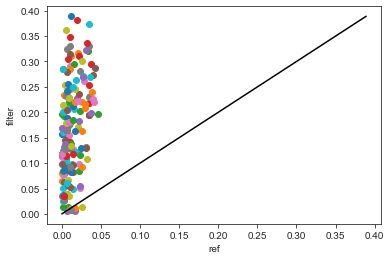

In [86]:
# make random circuits 
N_circs = 350
depth = 20
new_circ_list = []
for n in range(N_circs):
    new_circ_list.append(random_circuit(depth, MODEL_PACK.processor_spec()))
new_circ_list = _circ.to_circuits(circ_list) 

compare_models(noise_model, ref_model, filter_model, new_circ_list, 'ref', 'filter')

[[0.71470713 0.30528106]
 [0.30528106 0.90461953]]


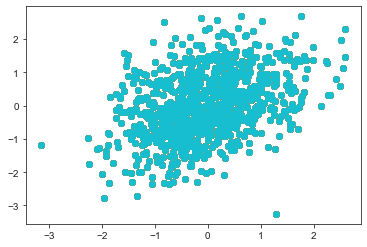

In [41]:
en = make_gaussian_ensemble(1000, np.zeros(2), np.array([[0.7, 0.3], [0.3, 0.9]]))

print(ensemble_covar(en))

for idx, e in enumerate(en.T):
    plt.scatter(en[0], en[1])